# Comienzo el análisis de los datos

Cargo las librerías, como voy a graficar además de pandas voy a usar matplotlib y folium (para el mapa)

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import folium

Matplotlib is building the font cache; this may take a moment.


Cargo la base de datos de recorridos y usuarios

In [2]:
recorridos_usuarios_3meses = pd.read_csv("../data/processed/recorridos_usuarios_3meses.csv", sep=',', encoding='utf-8')


In [4]:
recorridos_usuarios_3meses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285581 entries, 0 to 285580
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id_usuario                  285581 non-null  int64  
 1   genero_usuario              285581 non-null  object 
 2   edad_usuario                285581 non-null  int64  
 3   fecha_alta                  285581 non-null  object 
 4   hora_alta                   285581 non-null  object 
 5   id_recorrido                285581 non-null  int64  
 6   duracion_recorrido          285581 non-null  int64  
 7   fecha_origen_recorrido      285581 non-null  object 
 8   id_estacion_origen          285581 non-null  int64  
 9   nombre_estacion_origen      285581 non-null  object 
 10  direccion_estacion_origen   285581 non-null  object 
 11  long_estacion_origen        285581 non-null  float64
 12  lat_estacion_origen         285581 non-null  float64
 13  fecha_destino_

# Preguntas

## ¿Cuál fue la cantidad total de viajes realizados por usuarios de entre 25 y 35 años durante los tres meses seleccionados?

Para responder voy a crear 2 variables, edad_inicial y edad_final con esos valores, voy a filtrar y voy a contar los viajes

In [5]:
edad_inicio = 25
edad_final = 35

recorridos_entre_25y35 = recorridos_usuarios_3meses[((recorridos_usuarios_3meses['edad_usuario']) >= edad_inicio) 
                                                    & ((recorridos_usuarios_3meses['edad_usuario']) <= edad_final)]

In [11]:
# Cantidad total de viajes
total_recorridos_25y35 = recorridos_entre_25y35.shape[0]
print(f"La cantidad de recorridos que realizaron las personas entre 25 y 35 años en los meses de julio, agosto y septiembre fue: {total_recorridos_25y35}")

La cantidad de recorridos que realizaron las personas entre 25 y 35 años en los meses de julio, agosto y septiembre fue: 80952


## ¿Cuáles fueron las 5 estaciones de inicio con mayor cantidad de viajes en esos tres meses?

Voy a agrupar las estaciones, y voy a tomar las 5 estaciones con mas viajes, las muestro en la tabla porque voy a usar esos datos para hacer los gráficos

In [13]:
# Agrupar por estación de inicio, latitud y longitud
top5_estaciones = (
    recorridos_usuarios_3meses.groupby(["id_estacion_origen", "nombre_estacion_origen", "lat_estacion_origen", "long_estacion_origen"])
    .size()
    .reset_index(name="cantidad_viajes")
    .sort_values("cantidad_viajes", ascending=False)
    .head(5)
)

# Mostrar el resultado
top5_estaciones


,id_estacion_origen,nombre_estacion_origen,lat_estacion_origen,long_estacion_origen,cantidad_viajes
334,516,368 - PLAZA DE LA SHOÁ,-34.570998,-58.423347,4603
10,14,014 - Pacifico,-34.577424,-58.426387,3769
3,5,005 - Plaza Italia,-34.580550,-58.420954,3736
97,152,152 - JULIETA LANTERI,-34.618164,-58.359631,3639
333,515,294 - PLAZOLETA RÍO DE LA PLATA,-34.574246,-58.414655,3320


Voy a utilizar esos datos para realizar un gráfico de barras

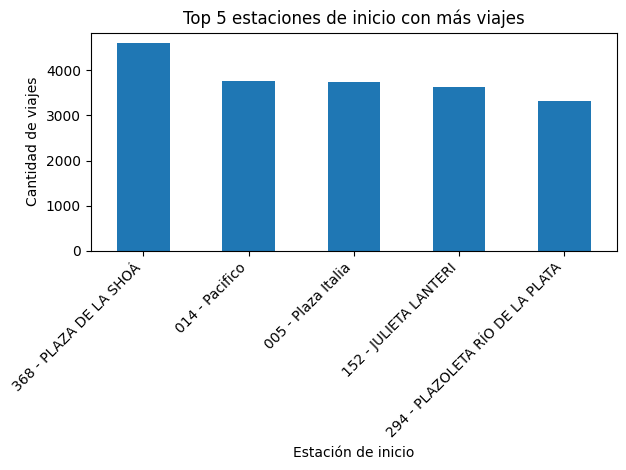

In [15]:
top5_estaciones.plot(
    x="nombre_estacion_origen",
    y="cantidad_viajes",
    kind="bar",
    legend=False,
    title="Top 5 estaciones de inicio con más viajes"
)

plt.ylabel("Cantidad de viajes")
plt.xlabel("Estación de inicio")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.savefig("../reports/figures/viajes_por_estaciones.png", dpi=300, bbox_inches="tight")


plt.show()

También mostraré en un mapa, teniendo en cuenta que cada estación tiene como datos su latitud y longitud

In [20]:
# con esto centro el mapa en CABA
mapa = folium.Map(location=[-34.6037, -58.3816], zoom_start=12)

# Agrego las estaciones al mapa
for _, row in top5_estaciones.iterrows():
    folium.Marker(
        location=[row["lat_estacion_origen"], row["long_estacion_origen"]],
        popup=f"{row['nombre_estacion_origen']}<br>Viajes: {row['cantidad_viajes']}",
        tooltip=row["nombre_estacion_origen"],
        icon=folium.Icon(color="blue", icon="bicycle", prefix="fa")
    ).add_to(mapa)


mapa
# lo guardo en reports
mapa.save("../reports/figures/top5_estaciones.html")

## Entre los usuarios frecuentes (más de 15 viajes en el período), ¿cuál es la distribución por género?

Al intentar responder esa consigna encuentro que hay 2 columnas que se refieren a género: genero_usuario y genero, las voy a comparar

In [24]:
# Crear una columna booleana que indique si coinciden
recorridos_usuarios_3meses["genero_coincide"] = (recorridos_usuarios_3meses['genero'] 
                                                 == recorridos_usuarios_3meses['genero_usuario'])

# Ver cuántas filas coinciden y cuántas no
comparacion = recorridos_usuarios_3meses["genero_coincide"].value_counts()
print(comparacion)


genero_coincide
True    285581
Name: count, dtype: int64


Noto que ambas columnas son iguales, continúo con la respuesta

Cuento la cantidad de recorridos por usuario con id_usuario y filtro los que tienen mas de 15

In [25]:
recorridos_por_usuario = recorridos_usuarios_3meses.groupby("id_usuario").size().reset_index(name="cantidad_viajes")

usuarios_frecuentes = recorridos_por_usuario[recorridos_por_usuario["cantidad_viajes"] > 15]


Hago un join para obtener para obtener el género del usuario frecuente

In [26]:
frecuentes_con_datos = recorridos_usuarios_3meses.merge(
    usuarios_frecuentes[["id_usuario"]],
    on="id_usuario",
    how="inner"
)

Finalmente cuento cuantos usuarios frecuentes hay por género

In [28]:
distribucion_genero = frecuentes_con_datos.groupby("genero")["id_usuario"].nunique()
print("la cantidad de usuarios frecuentes por")
print(distribucion_genero)

la cantidad de usuarios frecuentes por
genero
FEMALE    1421
MALE      2917
OTHER       57
Name: id_usuario, dtype: int64


y finalmente realizo un gráfico de barras con esos datos

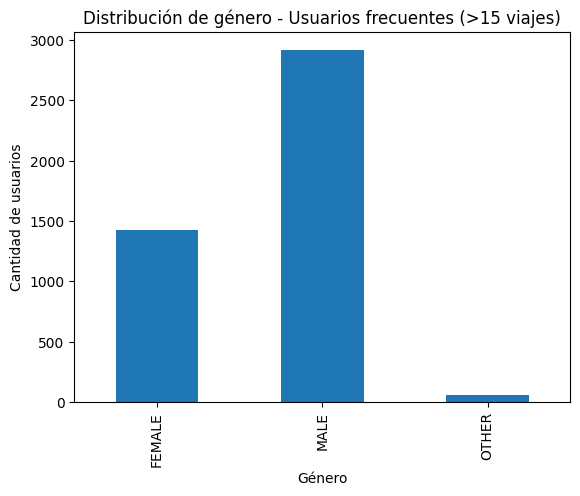

In [29]:
# Distribución de género - usuarios frecuentes
distribucion_genero.plot(
    kind="bar",
    title="Distribución de género - Usuarios frecuentes (>15 viajes)",
    ylabel="Cantidad de usuarios",
    xlabel="Género"
)

plt.savefig("../reports/figures/viajes_por_genero.png", dpi=300, bbox_inches="tight")

plt.show()